In [1]:
import pints
import pints.toy as toy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
from emupints.models import create_small_model, create_average_model, create_large_model

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

import string

# Problem parameters

In [2]:
# Create a model
real_model = pints.toy.GoodwinOscillatorModel()

n_parameters = real_model.n_parameters()
n_outputs = real_model.n_outputs()
real_parameters = np.array(real_model.suggested_parameters())
# real_parameters = np.array([0.15, 500])

values, times, noise_stds = emutils.simulate(real_model,
                                             parameters=real_parameters
                                            )

# Create an object with links to the model and time series
# or Multioutput depending on problem
if n_outputs == 1:
    problem = pints.SingleOutputProblem(real_model, times, values)
else:
    problem = pints.MultiOutputProblem(real_model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise_stds)

print("Number of parameters: ", n_parameters)
print("Parameter values: ", real_parameters)
print("Example problem values:\n", problem.values()[:5])

Number of parameters:  5
Parameter values:  [2.   4.   0.12 0.08 0.1 ]
Example problem values:
 [[0.0053695  0.05341836 1.97970296]
 [0.00628329 0.0635507  2.01034834]
 [0.00626832 0.0879833  2.2693364 ]
 [0.00497985 0.08948633 2.36183467]
 [0.00399724 0.09370882 2.76363978]]


In [3]:
# specify names for each parameter in the model
# default is alphabetical
index_to_param_name = dict(enumerate(string.ascii_lowercase[:n_parameters]))
index_to_param_name

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e'}

In [4]:
# creating distribution on bounds
# by default uniform with +-20% of original values
param_range = 0.2
real_params_lower = (1 - param_range) * real_parameters
real_params_upper = (1 + param_range) * real_parameters
#real_params_lower = [0.1, 400]
#real_params_upper = [0.2, 600]
bounds = pints.RectangularBoundaries(lower = real_params_lower, upper = real_params_upper)
log_prior = pints.UniformLogPrior(bounds)

print(list(zip(bounds.lower(), bounds.upper())))

[(1.6, 2.4), (3.2, 4.8), (0.096, 0.144), (0.064, 0.096), (0.08000000000000002, 0.12)]


In [5]:
# scoring function for CMA-ES and comparison
score = pints.SumOfSquaresError(problem)

# Toy problems contour graphs

Use to get an idea of continuity for high-dimensional inputs

In [6]:
fixed_parameters = emutils.fix_parameters(bounds)

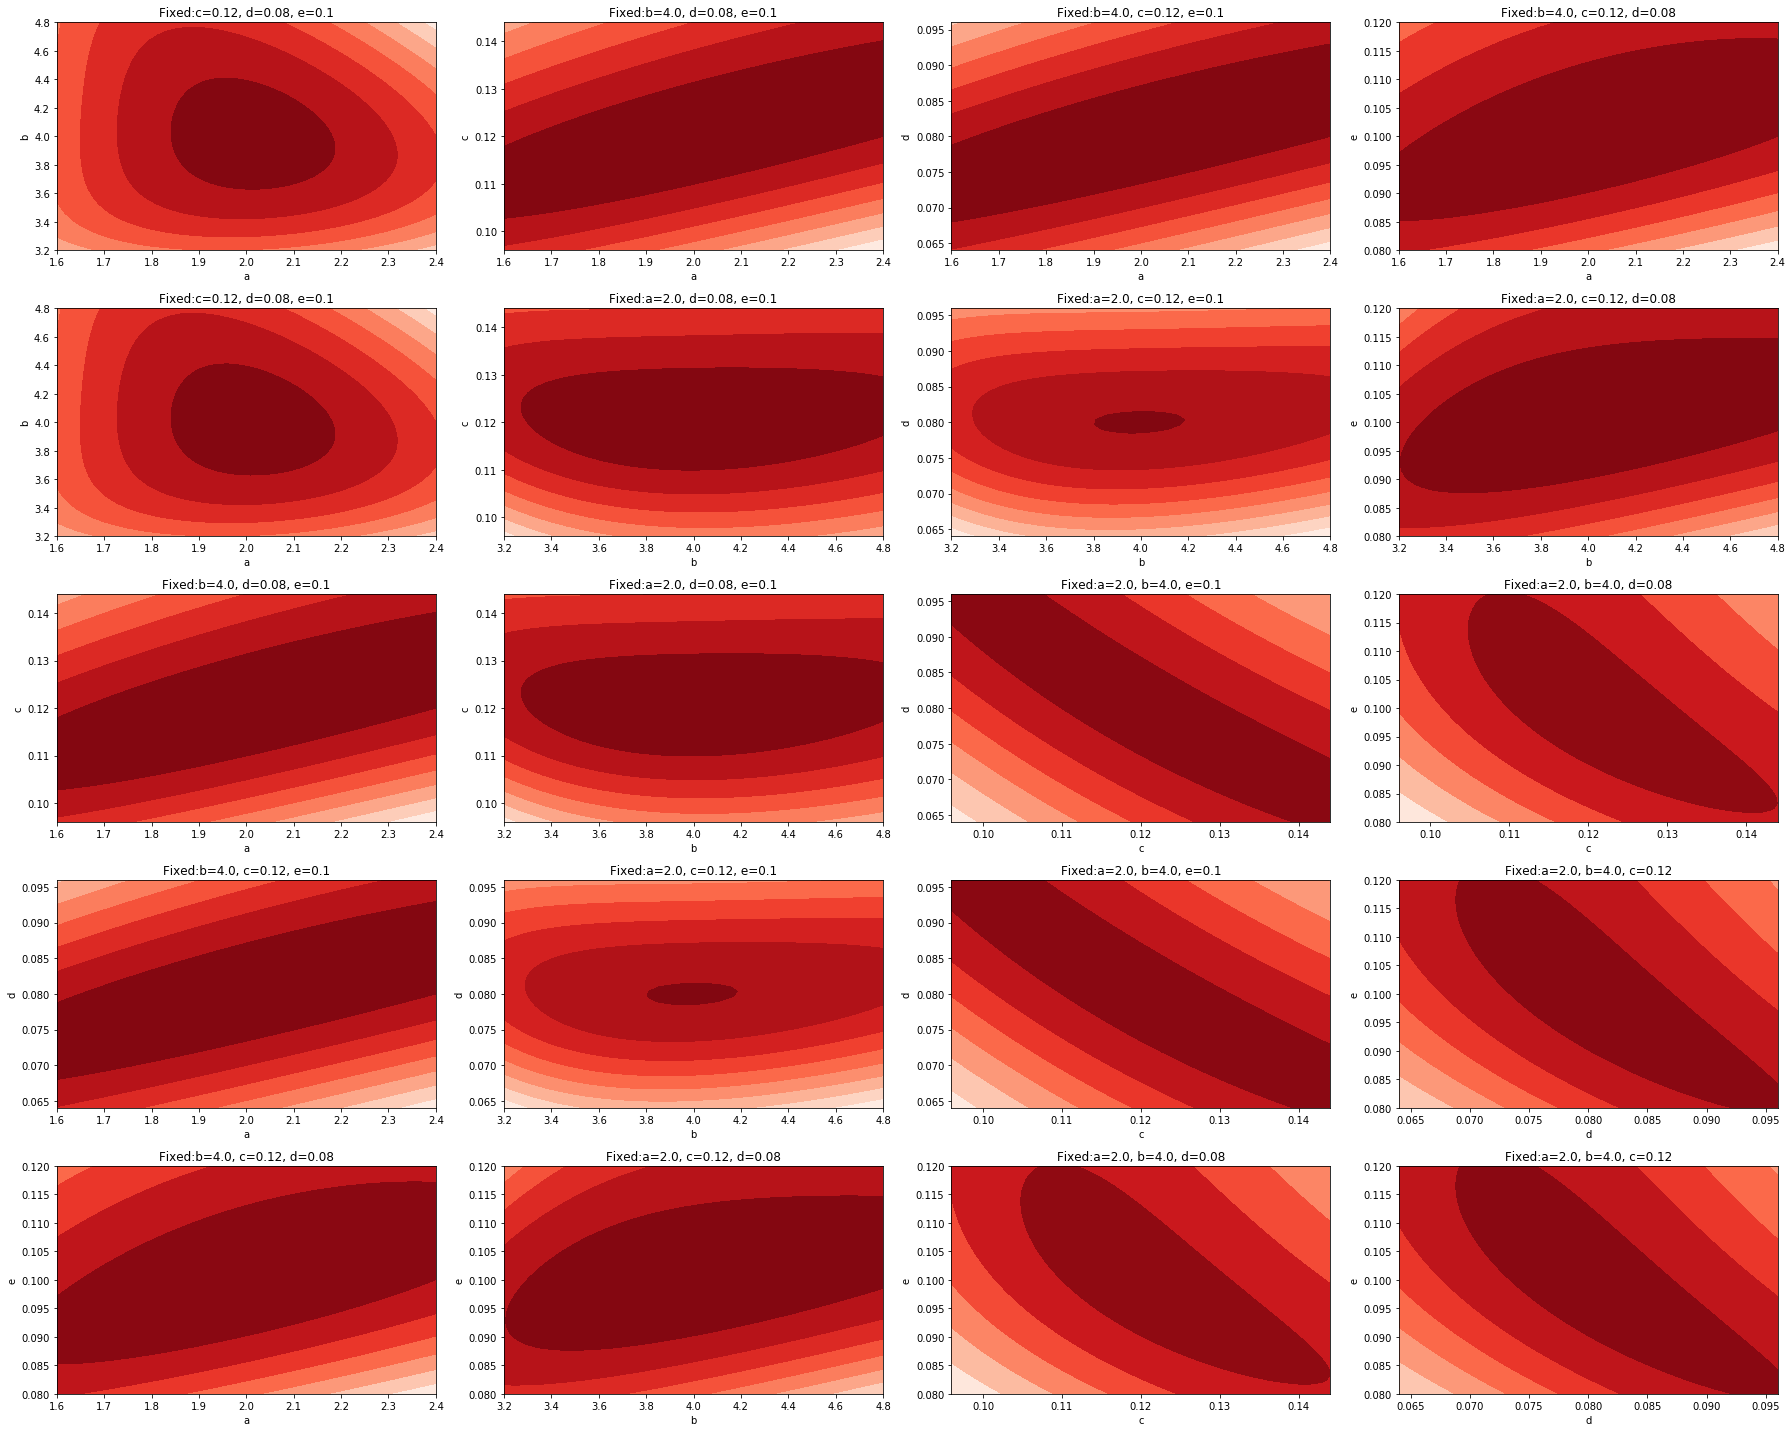

In [7]:
# row i has parameter i varying with every other parameter in the model
# however, x-axis is always taken by parameter that comes first in order
# i.e. lower index

if n_parameters > 2:  
    fig, ax = emuplt.plot_fixed_param_grid(
        real_log_likelihood,
        fixed_parameters,
        bounds,
        n_splits = 50, # number of splits on each free parameter
        shape = (n_parameters, n_parameters - 1),
    )

    plt.show(fig)

# Create dataset for training

In [8]:
# training size
training_size = 5000
test_size = 100

train_data = log_prior.sample(training_size)
train_target = np.apply_along_axis(real_log_likelihood, 1, train_data)

test_data = log_prior.sample(training_size)
test_target = np.apply_along_axis(real_log_likelihood, 1, test_data)

In [9]:
# normalize using standardisation for inputs

train_data_mean = np.mean(train_data, axis=0)
train_data_std = np.std(train_data, axis=0)

train_data_normalized = (train_data - train_data_mean) / train_data_std

# normalise test using same mean and var as train
test_data_normalized = (test_data - train_data_mean) / train_data_std


def normalize_input(x):
    return (x - train_data_mean) / train_data_std

# normalise target between [-1, 1]

train_target_min = np.min(train_target, axis = 0)
train_target_max = np.max(train_target, axis = 0)

train_target_normalized = 2 * (train_target - train_target_min) / (train_target_max - train_target_min) - 1
test_target_normalized = 2 * (test_target - train_target_min) / (train_target_max - train_target_min) - 1

def denormalize_prediction(x_norm):
    return (x_norm + 1) * (train_target_max - train_target_min) / 2 + train_target_min


# normalize data between [-1, 1] for output

# Create NN

In [10]:
# Hyperparameters
EPOCHS = 100
BATCH = 32
# learning_rate = 0.01

In [11]:
model = create_large_model(n_parameters)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               768       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 66,817
Trainable params: 66,817
Non-trainable params: 0
_________________________________________________________________


In [12]:
# use early stopping?
es_callback = keras.callbacks.EarlyStopping(monitor='mae')

In [13]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate)

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'] # mean absolute error
             )

In [14]:
history = model.fit(train_data_normalized, 
                    train_target_normalized, 
                    epochs=EPOCHS,
                    batch_size = BATCH,
                    validation_split=0.2,
                   )

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 0s 103us/step - loss: 0.0702 - mean_absolute_error: 0.1953 - val_loss: 0.0114 - val_mean_absolute_error: 0.0838
Epoch 2/100
4000/4000 [==============================] - 0s 41us/step - loss: 0.0043 - mean_absolute_error: 0.0480 - val_loss: 0.0018 - val_mean_absolute_error: 0.0329
Epoch 3/100
4000/4000 [==============================] - 0s 41us/step - loss: 0.0014 - mean_absolute_error: 0.0291 - val_loss: 0.0016 - val_mean_absolute_error: 0.0316
Epoch 4/100
4000/4000 [==============================] - 0s 43us/step - loss: 0.0011 - mean_absolute_error: 0.0248 - val_loss: 8.1602e-04 - val_mean_absolute_error: 0.0221
Epoch 5/100
4000/4000 [==============================] - 0s 48us/step - loss: 8.6471e-04 - mean_absolute_error: 0.0225 - val_loss: 8.1147e-04 - val_mean_absolute_error: 0.0226
Epoch 6/100
4000/4000 [==============================] - 0s 41us/step - loss: 6.7314e-04 - mean_abs

4000/4000 [==============================] - 0s 40us/step - loss: 6.3450e-05 - mean_absolute_error: 0.0062 - val_loss: 2.2816e-04 - val_mean_absolute_error: 0.0104
Epoch 48/100
4000/4000 [==============================] - 0s 40us/step - loss: 1.7785e-04 - mean_absolute_error: 0.0102 - val_loss: 1.7570e-04 - val_mean_absolute_error: 0.0101
Epoch 49/100
4000/4000 [==============================] - 0s 41us/step - loss: 3.2021e-04 - mean_absolute_error: 0.0133 - val_loss: 3.0922e-04 - val_mean_absolute_error: 0.0128
Epoch 50/100
4000/4000 [==============================] - 0s 79us/step - loss: 8.2856e-04 - mean_absolute_error: 0.0210 - val_loss: 3.4038e-04 - val_mean_absolute_error: 0.0147
Epoch 51/100
4000/4000 [==============================] - 0s 58us/step - loss: 1.5939e-04 - mean_absolute_error: 0.0095 - val_loss: 1.3882e-04 - val_mean_absolute_error: 0.0087
Epoch 52/100
4000/4000 [==============================] - 0s 43us/step - loss: 9.1987e-05 - mean_absolute_error: 0.0073 - val_lo

4000/4000 [==============================] - 0s 43us/step - loss: 4.0357e-05 - mean_absolute_error: 0.0049 - val_loss: 4.6013e-05 - val_mean_absolute_error: 0.0050
Epoch 94/100
4000/4000 [==============================] - 0s 58us/step - loss: 4.1462e-05 - mean_absolute_error: 0.0048 - val_loss: 8.8596e-05 - val_mean_absolute_error: 0.0070
Epoch 95/100
4000/4000 [==============================] - 0s 46us/step - loss: 1.1890e-04 - mean_absolute_error: 0.0082 - val_loss: 2.1074e-04 - val_mean_absolute_error: 0.0121
Epoch 96/100
4000/4000 [==============================] - 0s 44us/step - loss: 5.5902e-05 - mean_absolute_error: 0.0056 - val_loss: 9.7913e-05 - val_mean_absolute_error: 0.0077
Epoch 97/100
4000/4000 [==============================] - 0s 43us/step - loss: 3.7125e-05 - mean_absolute_error: 0.0047 - val_loss: 6.0143e-05 - val_mean_absolute_error: 0.0059
Epoch 98/100
4000/4000 [==============================] - 0s 55us/step - loss: 1.0617e-04 - mean_absolute_error: 0.0071 - val_lo

In [15]:
model.predict(normalize_input([real_parameters]))

array([[1.0025007]], dtype=float32)

In [16]:
loss, mae = model.evaluate(test_data_normalized, test_target_normalized)
print("Model loss: {:.10f}".format(loss))
print("Mean absolute error: {:.10f}".format(mae))

5000/5000 [==============================] - 0s 18us/step
Model loss: 0.0000986411
Mean absolute error: 0.0078927476


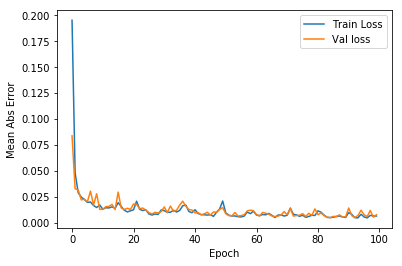

In [17]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
       label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
       label = 'Val loss')
plt.legend()

In [18]:
# calculate not normalized mean absolute error for test
test_prediction = denormalize_prediction(model.predict(test_data_normalized))
diff = np.mean(np.abs(test_prediction - train_target))
diff

2613.368193001432

# Plotting model

In [19]:
# create a callable object
# need to preprocess inputs and output
def emu(x):
    return denormalize_prediction(model.predict(normalize_input(np.array([x]))))

In [20]:
emu = emupints.EmulatorWrapper(emu, n_parameters)

In [21]:
if n_parameters == 2:
    # generate data for surfaces
    test_splits = 20 # number of splits along each axis
    r_grid, k_grid, test_data = emutils.generate_grid(bounds.lower(), 
                                                      bounds.upper(), 
                                                      test_splits)    

    emu_grid = emutils.predict_grid(emu, test_data)
    real_grid = emutils.predict_grid(real_log_likelihood, test_data)

    plt.figure(figsize = (10, 5))
    ax = emuplt.surface(r_grid, k_grid, emu_grid, 
                        title = "True log_likelihood",
                        alpha = 0.8,
                        cmap="Blues",
                        x_label = "r (growth rate)",
                        y_label = "k (carrying capacity)"
                       )

    ax.plot_surface(r_grid, k_grid, real_grid, cmap="Reds", alpha = .5)

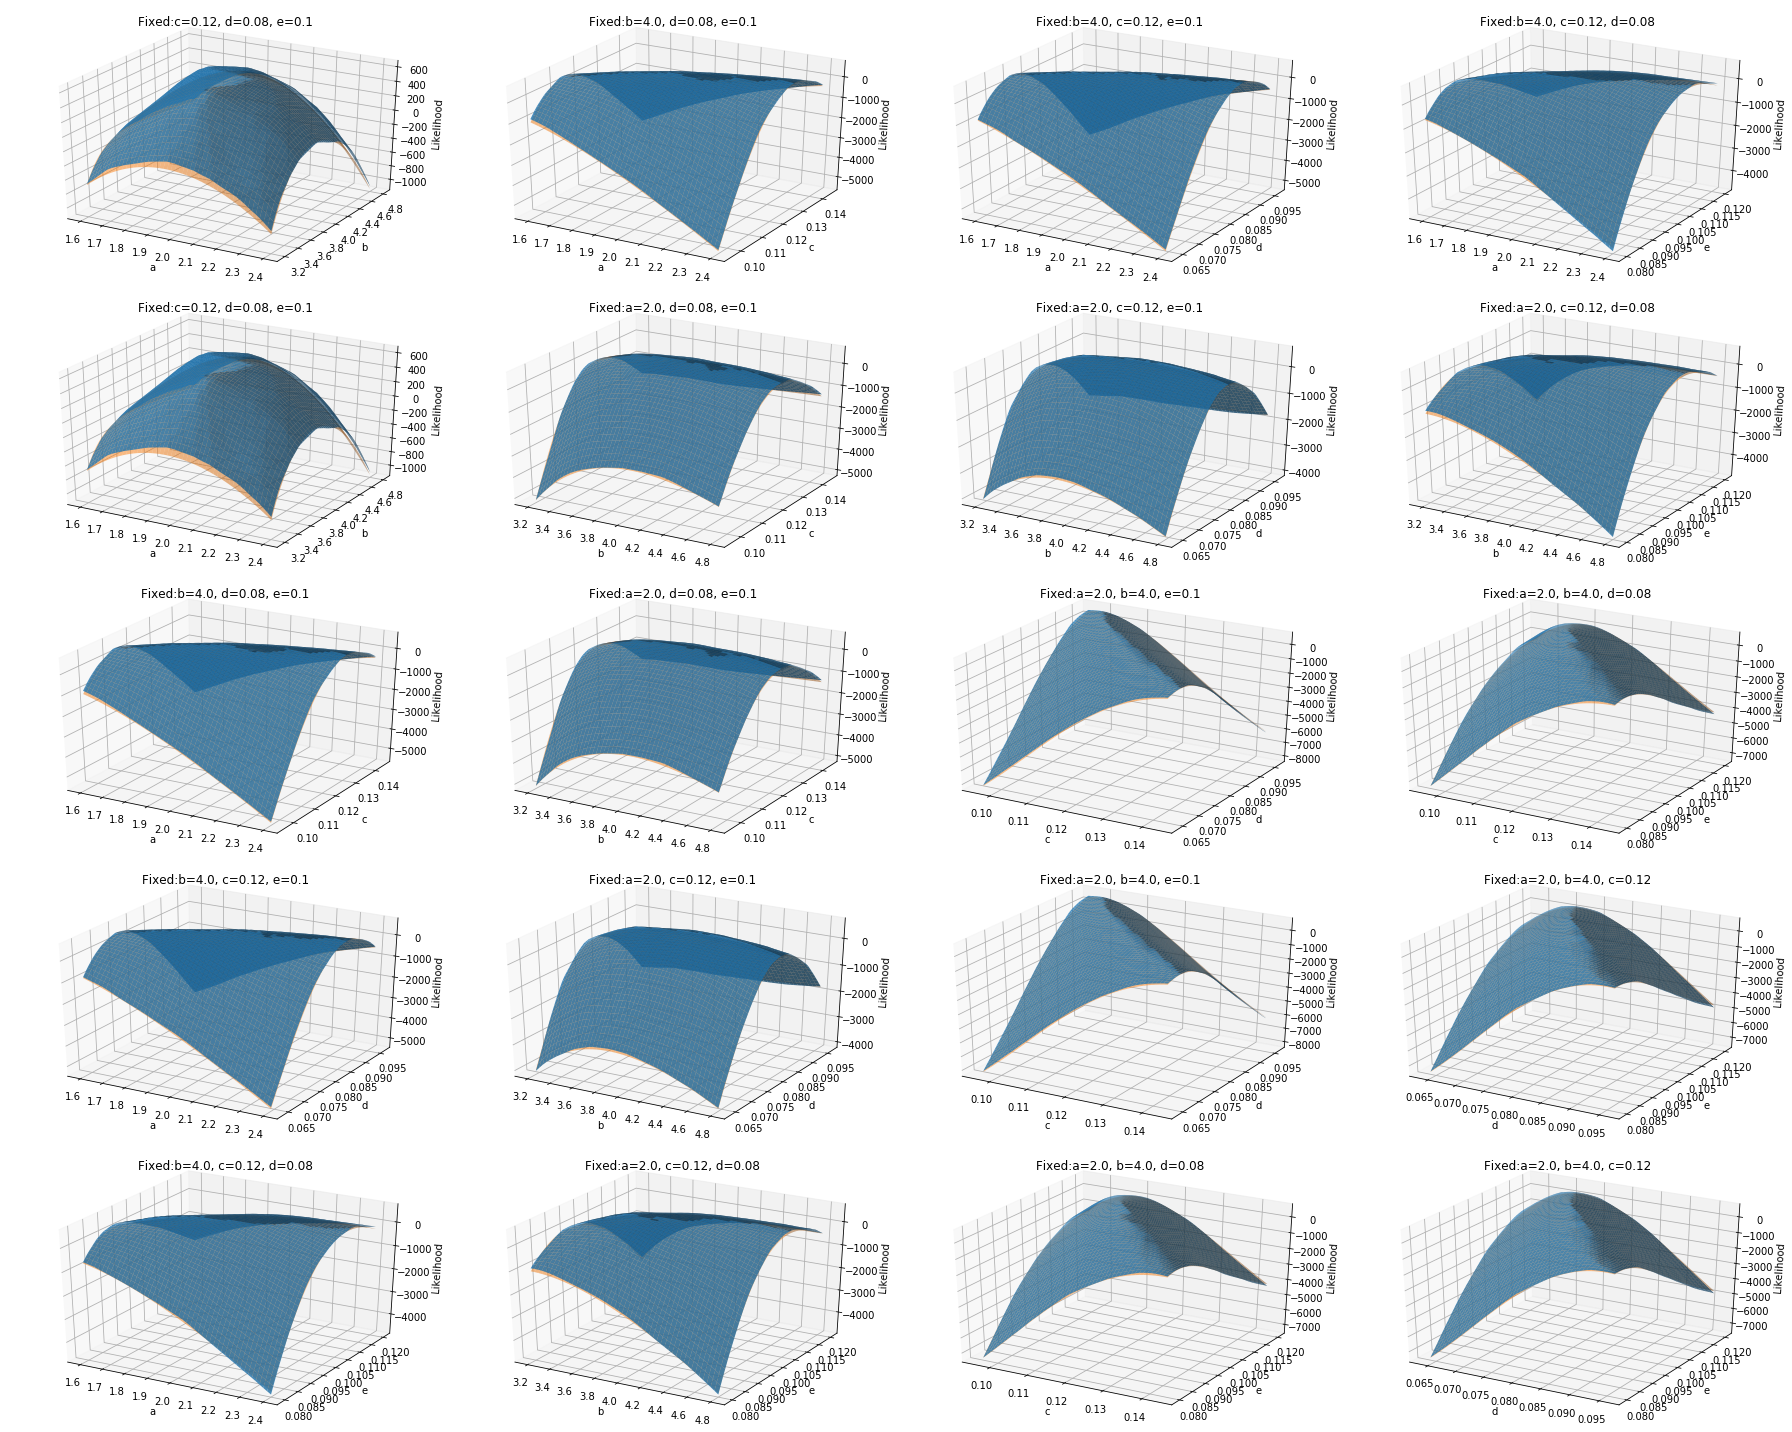

In [22]:
if n_parameters >=3:
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        n_splits = 50,
        shape = (n_parameters, n_parameters - 1),
        countour = False,
        additional_log_likelihoods = [real_log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

# Timing single prediction

In [23]:
%%timeit
emu(real_parameters)

330 µs ± 7.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%%timeit
real_log_likelihood(real_parameters)

2.02 ms ± 57.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Comparing MCMC run times

In [25]:
# for Logistic and Lotka-Voltera use default
mcmc_method = None
# mcmc_method = pints.PopulationMCMC
# mcmc_method = pints.AdaptiveCovarianceMCMC
# mcmc_method = pints.DifferentialEvolutionMCMC


# MCMC parameters
num_chains = 3
max_iters = 10000

In [26]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_posterior = pints.LogPosterior(emu, log_prior)
real_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [27]:
# returns some possible initial parameter values
# normal noise with 
def guess_params():
    return real_parameters * (1 + np.random.normal(scale=0.05))

In [28]:
x0 = guess_params()
# x0 = [0.17, 420]

In [29]:
# CMA-es
found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      0.201      0:00.1
1     16     0.201      0:00.1
2     24     0.201      0:00.1
3     32     0.201      0:00.1
20    168    0.189      0:00.4
40    328    0.188      0:00.8
60    488    0.188      0:01.1
80    648    0.188      0:01.5
100   808    0.188      0:01.8
120   968    0.188      0:02.2
140   1128   0.188      0:02.5
160   1288   0.188      0:02.9
180   1448   0.188      0:03.2
200   1608   0.188      0:03.5
220   1768   0.188      0:03.9
240   1928   0.188      0:04.2
260   2088   0.188      0:04.6
280   2248   0.188      0:04.9
300   2408   0.188      0:05.3
320   2568   0.188      0:05.6
340   2728   0.188      0:05.9
360   2888   0.188      0:06.2
361   2888   0.188      0:06.2
Halting: No significant change for 200 iterations.


In [30]:
print(found_value)
print(found_parameters)

0.18822409642679008
[2.02522696 3.89518284 0.11436546 0.08798738 0.09356926]


In [31]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

[array([2.02522696, 3.89518284, 0.11436546, 0.08798738, 0.09356926]),
 array([2.04547923, 3.93413467, 0.11550911, 0.08886726, 0.09450496]),
 array([2.00497469, 3.85623101, 0.1132218 , 0.08710751, 0.09263357])]

In [32]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 18.1 s, sys: 1.91 s, total: 20 s
Wall time: 16.7 s


In [33]:
%%time
# population MCMC
real_mcmc = pints.MCMCSampling(real_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 1min 11s, sys: 491 ms, total: 1min 11s
Wall time: 1min 12s


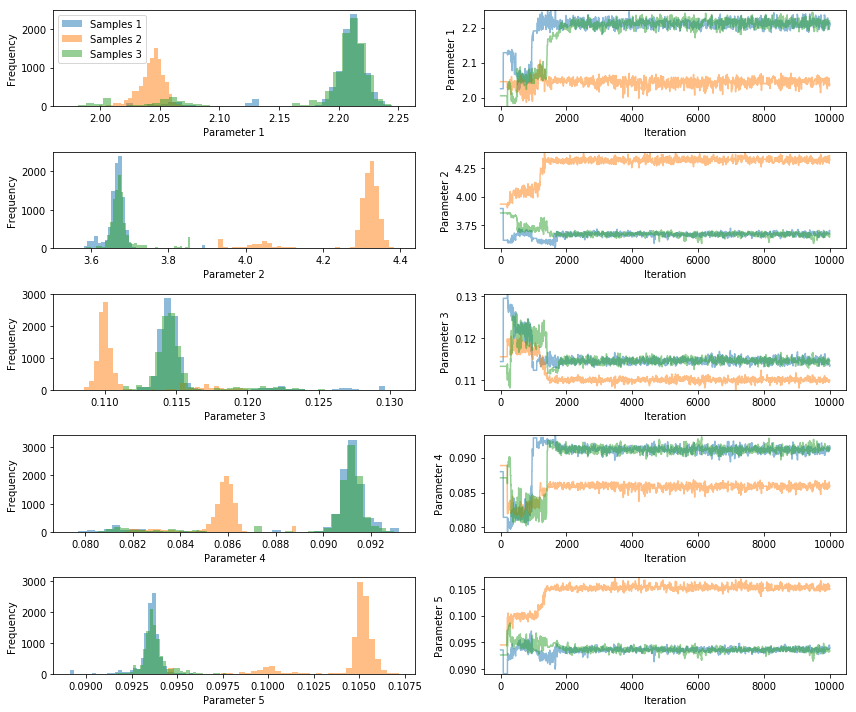

In [34]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

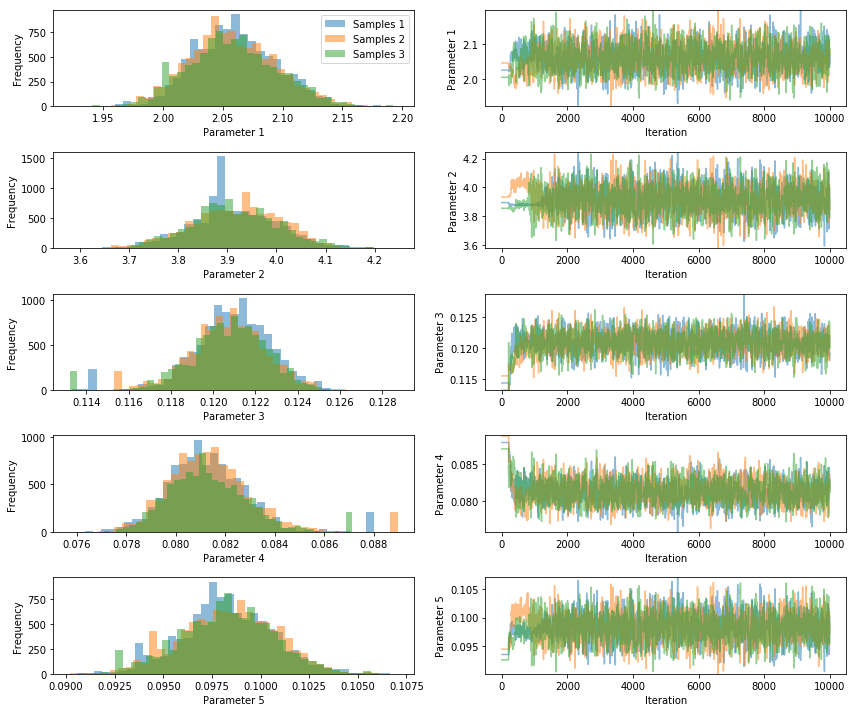

In [35]:
pints.plot.trace(real_chains)
plt.show()

In [36]:
chain = real_chains[0]

emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
real_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

diffs = np.abs(real_prediction - emu_prediction)

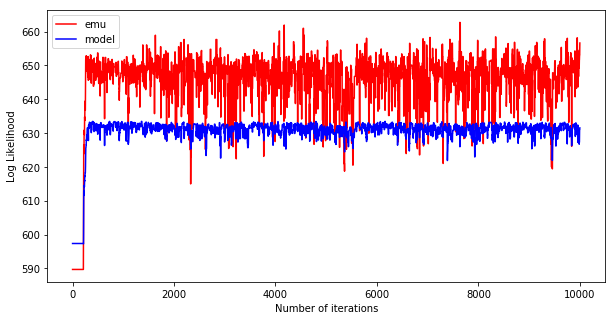

In [37]:
iters = range(len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color="Red", label='emu')
plt.plot(iters, real_prediction, color="Blue", label='model')
plt.legend()
plt.show()

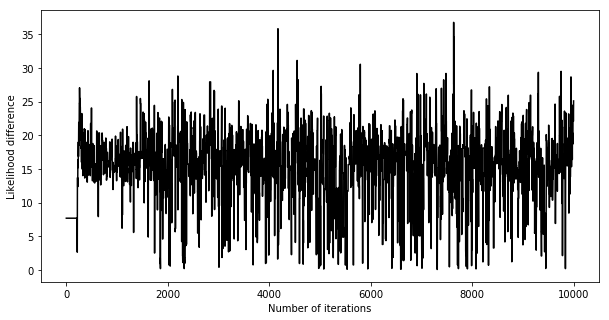

In [38]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood difference")
plt.plot(iters, diffs, color = "Black")
plt.show()